In [206]:
import csv
import random
import numpy as np
import scipy.special
from sklearn.model_selection import KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as mplColors
%matplotlib inline

In [207]:
class NeuralNetwork:
    def __init__(self, input_nodes, output_nodes, hidden_list, learning_rate):
        self.inodes = input_nodes
        self.hlist = hidden_list    # ex: [3,3,2]
        self.onodes = output_nodes

        self.lr = learning_rate

        self.w = []
        self.w.append(np.random.normal(0.0, pow(self.inodes, -0.5), (self.hlist[0], self.inodes)))
        for i in range(len(self.hlist)-1):
            self.w.append(np.random.normal(0.0, pow(self.hlist[i], -0.5), (self.hlist[i+1], self.hlist[i])))
        self.w.append(np.random.normal(0.0, pow(self.hlist[-1], -0.5), (self.onodes, self.hlist[-1])))

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)

    def query_detail(self, inputs):
        inputs = np.array(inputs)
        outputs = inputs
        detail_output = []
        for w in self.w:
            outputs = np.matmul(outputs, w.T)
            outputs = self.activation_function(outputs) # keep number between 0.0-1.0
            detail_output.append(outputs)
        return detail_output

    # Feed data to fix the model.
    def train(self, inputs, targets):
        outputs = self.query_detail(inputs)
        outputs.insert(0, np.array(inputs))
        
        # Get errors on each nodes except inputs
        errors = [targets - outputs[-1]]

        for i in range(len(self.w)-1):
            w = self.w[len(self.w)-i-1]
            errors.append(np.matmul(errors[i], w))
        errors = list(reversed(errors))

        # Propagate back to fix the weights
        indices = list(range(len(self.w)))
        for i in reversed(indices):
            err = np.array([errors[i] * outputs[i+1] * (1 - outputs[i+1])])
            outT = np.array([outputs[i]]).T
            self.w[i] += np.matmul(outT, err).T * self.lr

    # Feed data to get result from the model.
    def query(self, inputs):
        return self.query_detail(inputs)[-1]

In [208]:
# Obtain our data
data = []
with open('data/twomoon_500.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        f_row = [float(i) for i in row]
        data.append(f_row)

random.shuffle(data)
npdata = np.array(data)
X = npdata[:,:-1]
# X = preprocessing.normalize(X)
y = npdata[:,-1]

In [209]:
# Cross validation
folds = 10
kf = KFold(n_splits=folds)
kf.get_n_splits(X)

Xf = []
yf = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    Xf.append([X_train, X_test])
    yf.append([y_train, y_test])

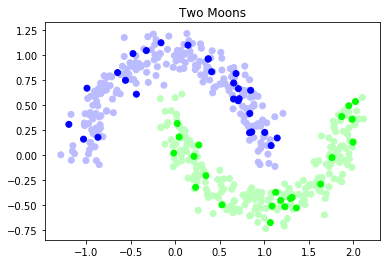

In [210]:
# Show one fold
fidx = 0
colors = ['#bbbbff','#bbffbb']
testColors = ['#0000ff','#00ff00']
XtrShow = Xf[fidx][0]
ytrShow = yf[fidx][0]
XtsShow = Xf[fidx][1]
ytsShow = yf[fidx][1]

fig, ax = plt.subplots()
ax.set_title('Two Moons')
ax.scatter(XtrShow[:,0], XtrShow[:,1], c=ytrShow, cmap=mplColors.ListedColormap(colors))
ax.scatter(XtsShow[:,0], XtsShow[:,1], c=ytsShow, cmap=mplColors.ListedColormap(testColors))
plt.show()

In [211]:
# Setup neural network
num_inputs = len(X[0])
num_outputs = 2
hidden_list = [3]
learning_rate = 0.3

print("in:{} out:{} h:{} rate:{}".format(num_inputs, num_outputs, hidden_list, learning_rate))

nn = []
for i in range(folds):
    nn.append(NeuralNetwork(num_inputs, num_outputs, hidden_list, learning_rate))

in:2 out:2 h:[3] rate:0.3


In [212]:
%%time
# Train
for i in range(folds):
    Xtrain = Xf[i][0]
    ytrain = yf[i][0]

    epochs = 5
    for e in range(epochs): # Train same dataset 'epochs' times.
        for train_idx in range(len(Xtrain)):
            xt = Xtrain[train_idx]
            yt = ytrain[train_idx]

            # Change label format into output nodes, correct label will be 0.99.
            targets = np.zeros(num_outputs) + 0.01
            targets[int(yt)] = 0.99

            nn[i].train(xt, targets)

Wall time: 876 ms


In [213]:
%%time
# Test
rates = []
for i in range(folds):
    Xtest = Xf[i][1]
    ytest = yf[i][1]
    correct = 0
    for test_idx in range(len(Xtest)):
        xt = Xtrain[test_idx]
        yt = ytrain[test_idx]

        outputs = list(nn[i].query(xt))
        label = outputs.index(max(outputs))
        if label == int(yt):
            correct += 1
    correct_rate = float(correct) / len(Xtest)
    rates.append(correct_rate)
    print("-- Fold {0}: {1}/{2} = {3:.2%}".format(i+1, correct, len(Xtest), correct_rate))

print("Avg: {:.2%}".format(np.average(rates)))

-- Fold 1: 43/50 = 86.00%
-- Fold 2: 43/50 = 86.00%
-- Fold 3: 43/50 = 86.00%
-- Fold 4: 43/50 = 86.00%
-- Fold 5: 43/50 = 86.00%
-- Fold 6: 43/50 = 86.00%
-- Fold 7: 43/50 = 86.00%
-- Fold 8: 43/50 = 86.00%
-- Fold 9: 43/50 = 86.00%
-- Fold 10: 42/50 = 84.00%
Avg: 85.80%
Wall time: 12 ms
